In [1]:
%load_ext autoreload
%autoreload 2
import sys
from ridge_utils.DataSequence import DataSequence
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
import seaborn as sns
from os.path import join
from collections import defaultdict
import numpy as np
import random
import sasc.viz
import joblib
import dvu
import sys
sys.path.append('../notebooks')
from tqdm import tqdm
from sasc.config import FMRI_DIR, STORIES_DIR, RESULTS_DIR
from neuro.config import repo_dir, PROCESSED_DIR
from neuro import analyze_helper, viz
from neuro.features.qa_questions import get_questions, get_merged_questions_v3_boostexamples
# flatmaps_per_question = __import__('06_flatmaps_per_question')
import viz
import gemv

Note, this notebook requires first running `03_export_qa_flatmaps.ipynb` into `df_qa_dict.pkl` files for each subject.

### load gemv average flatmaps

In [2]:
gemv_avgs_pilot = joblib.load(join(
    RESULTS_DIR, "processed", "flatmaps", 'resps_avg_dict_pilot.pkl'))
gemv_avgs_pilot5 = joblib.load(join(
    RESULTS_DIR, "processed", "flatmaps", 'resps_avg_dict_pilot5.pkl'))
gemv_avg_flatmaps = gemv_avgs_pilot | gemv_avgs_pilot5
qa_list, gemv_list = gemv.get_matched_lists()

In [3]:
# # check that gpt4 was run for all the questions
# subject = 'UTS02'
# setting = 'individual_gpt4'
# flatmaps_qa = joblib.load(
#     join(PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
# for k in qa_list:
#     assert k in flatmaps_qa.keys()

### make comparisons

lens [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
/home/chansingh/fmri/qa_results/gemv/corrs_individual_gpt4
lens [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
/home/chansingh/fmri/qa_results/gemv/corrs_individual_gpt4
lens [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
/home/chansingh/fmri/qa_results/gemv/corrs_individual_gpt4
lens [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

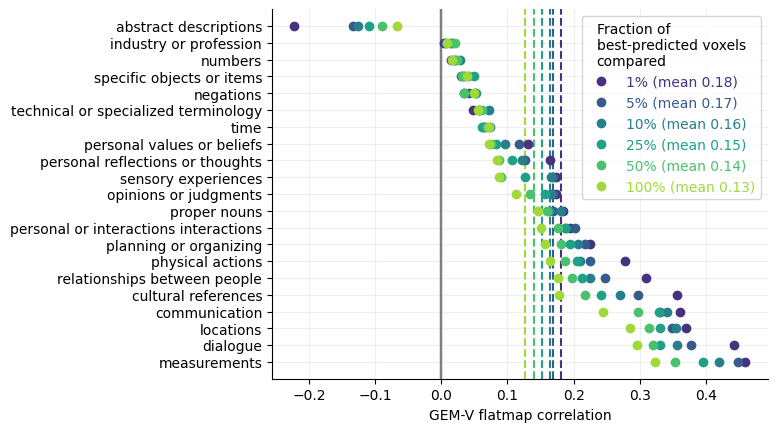

In [4]:
# load qa weights
subject = 'UTS02'
frac_voxels_to_keep_list = [0.01, 0.05, 0.1, 0.25, 0.5, 1]
for j, frac_voxels_to_keep in enumerate(frac_voxels_to_keep_list):
    flatmaps_qa_list = defaultdict(list)
    # , 'individual_35', full_35', 'shapley_35', 'individual_gpt4',
    # for setting in ['individual_gpt4', 'shapley_35']:
    # for setting in ['individual_gpt4', 'individual_gpt4_wordrate']:
    for setting in ['individual_gpt4']:
        # for setting in ['full_35_wordrate']:
        flatmaps_qa = joblib.load(
            join(PROCESSED_DIR, subject.replace('UT', ''), setting + '.pkl'))
        for q in flatmaps_qa.keys():
            flatmaps_qa_list[q].append(flatmaps_qa[q])
    print('lens', [len(flatmaps_qa_list[q]) for q in flatmaps_qa_list.keys()])
    flatmaps_qa = {
        q: np.mean(flatmaps_qa_list[q], axis=0)
        for q in flatmaps_qa_list.keys()}

    # select what to plot
    # df_qa_dict = joblib.load(f'df_qa_dict_{subject.replace("UT", "")}.pkl')
    questions_names_df = pd.DataFrame({
        'qa_weight': qa_list,
        'gemv_avg_resp': gemv_list,
    })
    # filter only questions that exist in the flatmaps
    questions_names_df = questions_names_df[questions_names_df['qa_weight'].isin(
        flatmaps_qa.keys())]

    if isinstance(flatmaps_qa, pd.DataFrame):
        questions_names_df = questions_names_df[questions_names_df['qa_weight'].isin(
            flatmaps_qa.index)]
        flatmaps_qa = flatmaps_qa.loc[questions_names_df['qa_weight'].values]['weights'].values
    else:
        flatmaps_qa = [flatmaps_qa[q]
                       for q in questions_names_df['qa_weight'].values]
    flatmaps_gemv = [
        gemv_avg_flatmaps[q]
        for q in questions_names_df['gemv_avg_resp'].values]
    # print(len(flatmaps_qa), len(flatmaps_gemv))

    titles_gt = questions_names_df['gemv_avg_resp'].apply(
        lambda x: x[0]).astype(str)

    corrs_test = joblib.load(join(PROCESSED_DIR, subject.replace(
        'UT', ''), 'corrs_test_35.pkl')).values[0]
    # threshold top-20%
    corrs_test_mask = (corrs_test >= np.percentile(
        corrs_test, 100 * (1 - frac_voxels_to_keep))).astype(bool)

    # # save flatmaps
    # if frac_voxels_to_keep in [0.1, 1]:

    #     # apply mask as nans
    #     for i in range(len(flatmaps_qa)):
    #         flatmaps_qa[i][~corrs_test_mask] = np.nan
    #         flatmaps_gemv[i][~corrs_test_mask] = np.nan

    #     for i in tqdm(range(len(flatmaps_qa))):
    #         sasc.viz.quickshow(
    #             flatmaps_qa[i],
    #             subject=subject,
    #             fname_save=join(repo_dir, 'qa_results', 'gemv', subject,
    #                             f'frac_voxels={frac_voxels_to_keep}',
    #                             setting, f'{titles_gt[i]}.png'),
    #             cmap='RdYlBu_r',
    #         )

    #         sasc.viz.quickshow(
    #             flatmaps_gemv[i],
    #             subject=subject,
    #             fname_save=join(repo_dir, 'qa_results', 'gemv', subject,
    #                             f'frac_voxels={frac_voxels_to_keep}',
    #                             'gemv', f'{titles_gt[i]}.png'),
    #             cmap='RdYlBu_r',
    #         )

    flatmaps_qa = [flatmaps_qa[i][corrs_test_mask]
                   for i in range(len(flatmaps_qa))]
    flatmaps_gemv = [flatmaps_gemv[i][corrs_test_mask]
                     for i in range(len(flatmaps_gemv))]

    corrs = viz._calc_corrs(
        flatmaps_qa,
        flatmaps_gemv,
        titles_qa=[analyze_helper.abbrev_question(q)
                   for q in questions_names_df['qa_weight'].astype(str)],
        titles_gt=titles_gt,
    )
    corrs_df = pd.DataFrame({'corrs': np.diag(
        corrs.values), 'questions': corrs.columns}).sort_values('corrs', ascending=False)
    corrs_df.to_pickle(join(repo_dir, 'qa_results', 'gemv',
                            setting + '_corrs_df.pkl'))

    colors = sns.color_palette('viridis', len(frac_voxels_to_keep_list))
    viz.corr_bars(
        corrs,
        out_dir_save=join(repo_dir, 'qa_results', 'gemv',
                          'corrs_' + setting),
        xlab='GEM-V',
        color=colors[j],
        label=f'{frac_voxels_to_keep * 100:.0f}%',
    )
    # plt.savefig(join(out_dir_save, 'corrs_barplot.pdf'), bbox_inches='tight')
    # plt.savefig(join(out_dir_save, 'corrs_barplot.png'),
    #             bbox_inches='tight', dpi=300)
    # plt.show()

# center legend text
plt.legend(title='Fraction of\nbest-predicted voxels\ncompared',
           labelcolor='linecolor')
# plt.tight_layout()
plt.savefig(join(repo_dir, 'qa_results', 'gemv', subject, 'corrs_barplot.pdf'),
            bbox_inches='tight')
plt.savefig(join(repo_dir, 'qa_results', 'gemv', subject, 'corrs_barplot.png'),
            bbox_inches='tight', dpi=300)
plt.show()

# Look at merged flatmaps

In [ ]:
corrs_df = pd.read_pickle(join(repo_dir, 'qa_results', 'gemv',
                               setting + '_corrs_df.pkl'))

In [ ]:
img_parent_dir = join(repo_dir, 'qa_results', 'gemv',
                      subject, 'frac_voxels=0.1')
img_dir1 = join(img_parent_dir, 'gemv')
img_dir2 = join(img_parent_dir, setting)

# read images and combine them with their filenames on a single plot
# fnames = os.listdir(img_dir1)
# fnames = [f for f in fnames if f.endswith('.png')]
# only keep the ones that are in both directories
# fnames = [f for f in fnames if f in os.listdir(img_dir2)]


# corrs = corrs.sort_values('corrs', ascending=False)
fnames = [v + '.png' for v in corrs_df['questions'].values]

n = len(fnames)
C = 4
R = int(np.ceil(n / C))

fig, axs = plt.subplots(R, C, figsize=(C * 3.2, R * 1))
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].axis('off')
for i, fname in enumerate(fnames):
    img1 = plt.imread(join(img_dir1, fname))
    img2 = plt.imread(join(img_dir2, fname))
    axs[i].imshow(np.concatenate([img1, img2], axis=1))
    axs[i].set_title(
        f'{fname[:-4]} ({corrs_df["corrs"].values[i]:0.3f})', fontsize=8)

# add text in bottom right of figure
fig.text(0.99, 0.01, f'{subject}\nGEMV on left, QA on right',
         ha='right', va='bottom', fontsize=8)
plt.tight_layout()
plt.savefig(join(img_parent_dir, f'flatmaps_{setting}_{subject}.png'), dpi=300)
plt.close()